# Import required libraries and define the required functions

In [1]:
import cv2 as cv
import numpy as np
import urllib.request
from matplotlib import pyplot as plt

from ultralytics import YOLO
import torch

In [8]:
focal_length = 694
baseline = 0.13

def downScale(image, n):
    modifiedImage = np.floor_divide(image, 2**n)
    return modifiedImage

def upScale(image, n):
    modifiedImage = np.multiply(image, 2**n) 
    return modifiedImage.astype(np.uint8)

def disparity_to_depth(disparity_map):
    disparity_map[disparity_map <= 0] = 0.1
    depth_map = (focal_length * baseline) / disparity_map

    return depth_map

def viewImages(original, modified, text): 
    plt.figure(figsize=(9,9)) 

    plt.subplot(1,2,1) 
    plt.imshow(original) 
    plt.title('Orignal') 
    plt.axis('off') 

    plt.subplot(1,2,2) 
    plt.imshow(modified) 
    plt.title(text) 
    plt.axis('off') 
    plt.tight_layout()
    plt.savefig(f'./maps/{text}', dpi=300)


# For testing purposes, import stored images.

In [3]:
left_img = cv.imread("./images/L_2.png", cv.IMREAD_GRAYSCALE)
right_img = cv.imread("./images/R_2.png", cv.IMREAD_GRAYSCALE)

left_color_img = cv.imread("./images/L_2.png", cv.IMREAD_COLOR)
right_color_img = cv.imread("./images/R_2.png", cv.IMREAD_COLOR)

# Getting images using ESP Cameras

In [8]:
left_url = 'http://192.168.247.216/cam-hi.jpg'
right_url = 'http://192.168.247.172/cam-hi.jpg'


l_img_resp=urllib.request.urlopen(left_url)
r_img_resp=urllib.request.urlopen(right_url)

l_imgnp=np.array(bytearray(l_img_resp.read()),dtype=np.uint8)
r_imgnp=np.array(bytearray(r_img_resp.read()),dtype=np.uint8)

left_color_img = cv.imdecode(l_imgnp,1)
right_color_img = cv.imdecode(r_imgnp,1)

left_img = cv.cvtColor(left_color_img, cv.COLOR_BGR2GRAY)
right_img = cv.cvtColor(right_color_img, cv.COLOR_BGR2GRAY)


# Getting images using USB cameras

In [ ]:
cap_left = cv.VideoCapture(0)
cap_right=cv.VideoCapture(1)

rect_left, left_img = cap_left.read()
rect_right, right_img = cap_right.read()

# Stereo BLock matching Algorithm

In [4]:
# Use SAD Algorithm for calculate disparities ---------------------------------------------------------------
def compute_disparity_SAD(left_img, right_img, block_size, disparities):
    h, w = left_img.shape
    disparity = np.zeros((h, w), np.uint8)
    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1,
                                       x - half_block:x + half_block + 1]

            min_sad = float('inf')
            best_disparity = 0

            for d in range(disparities):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1,
                                                 x_right - half_block:x_right + half_block + 1]

                    sad = np.sum(np.abs(left_block.astype(np.int32) - right_block.astype(np.int32)))

                    if sad < min_sad:
                        min_sad = sad
                        best_disparity = d

            disparity[y, x] = best_disparity

    return disparity

# Use SSD Algorithm for calculate disparities ---------------------------------------------------------------
def compute_disparity_SSD(left_img, right_img, block_size, max_disparity):
    h, w = left_img.shape

    disparity = np.zeros((h, w), np.uint8)

    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1,
                                       x - half_block:x + half_block + 1]

            min_ssd = float('inf')
            best_disparity = 0

            for d in range(max_disparity):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1,
                                                 x_right - half_block:x_right + half_block + 1]

                    ssd = np.sum((left_block.astype(np.int32) - right_block.astype(np.int32)) ** 2)

                    if ssd < min_ssd:
                        min_ssd = ssd
                        best_disparity = d
            disparity[y, x] = best_disparity

    return disparity

# Use NCC Algorithm for calculate disparities ---------------------------------------------------------------
def compute_disparity_NCC(left_img, right_img, block_size, max_disparity):

    h, w = left_img.shape

    disparity_map = np.zeros((h, w), np.float32)

    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

            left_mean = np.mean(left_block)

            best_ncc = -1
            best_disparity = 0

            for d in range(max_disparity):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1, x_right - half_block:x_right + half_block + 1]

                    right_mean = np.mean(right_block)

                    numerator = np.sum((left_block - left_mean) * (right_block - right_mean))
                    left_norm = np.sum((left_block - left_mean) ** 2)
                    right_norm = np.sum((right_block - right_mean) ** 2)
                    denominator = np.sqrt(left_norm * right_norm)

                    if denominator > 0:
                        ncc_score = numerator / denominator

                        if ncc_score > best_ncc:
                            best_ncc = ncc_score
                            best_disparity = d

            disparity_map[y, x] = best_disparity

    return disparity_map



# Stereo Processing

In [5]:
# Create and View Disparity maps

SAD, SSD, NCC = 1, 2, 3
def disparity_map(left_img, right_img, block, disparities, text, type):
    if type == SAD:
        disparity = compute_disparity_SAD(left_img, right_img, block, disparities)
    elif type == SSD:
        disparity = compute_disparity_SAD(left_img, right_img, block, disparities)
    elif type == NCC:
        disparity = compute_disparity_SAD(left_img, right_img, block, disparities)
    
    depth = disparity_to_depth(disparity)

    viewImages(left_img, disparity, text)
    plt.savefig('./maps/' + text + '.png', dpi=300)

    viewImages(left_img, depth, text)
    plt.savefig('./maps/' + text + '.png', dpi=300)

def get_disparity_map(left_img, right_img, block, disparities, type):
    if type == SAD:
        disparity = compute_disparity_SAD(left_img, right_img, block, disparities)
    elif type == SSD:
        disparity = compute_disparity_SAD(left_img, right_img, block, disparities)
    elif type == NCC:
        disparity = compute_disparity_SAD(left_img, right_img, block, disparities)

    depth = disparity_to_depth(disparity)

    return disparity, depth

# Creating Disparity Maps and Depth Maps

In [ ]:
# Use OpenCV for creating Depth Map

fig, axs = plt.subplots(16, 9, figsize=(150,150))

for i in range(16):
    for j in range(9):
        stereo = cv.StereoBM_create(numDisparities=16 * (i + 1), blockSize=(2 * j + 5))

        disparity_1 = stereo.compute(left_img, right_img)
        
        axs[i, j].imshow(disparity_1)
        axs[i, j].axis('off')
        axs[i, j].set_title("Disparity 01")

plt.tight_layout()
plt.savefig('./maps/original_disparities.png', dpi=300)
plt.show()

In [ ]:
disparity_map(left_img, right_img, 10, 20, "SAD - Depth Map", SAD)

C:\Users\Tharusha\AppData\Local\Temp\ipykernel_41408\1588185461.py:14: RuntimeWarning: divide by zero encountered in divide
  depth_map = (focal_length * baseline) / disparity_map


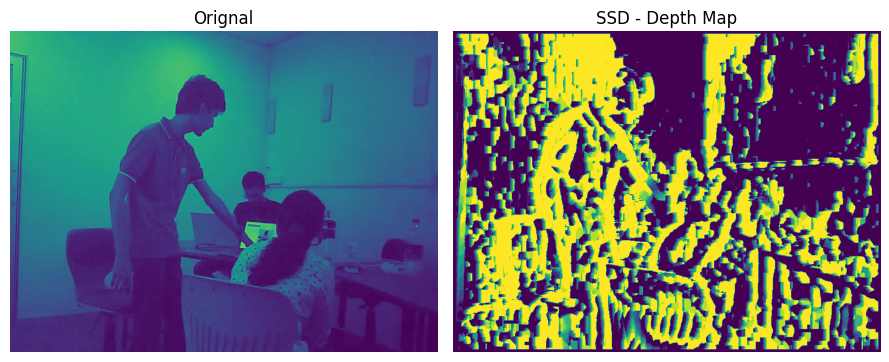

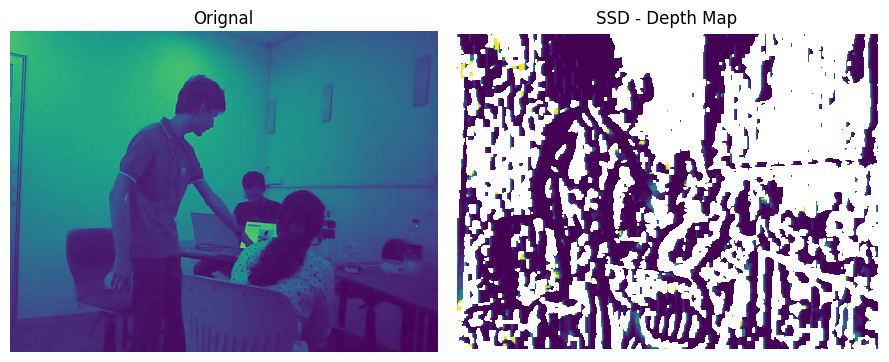

In [10]:

disparity_map(left_img, right_img, 10, 10, "SSD - Depth Map", SSD)

In [ ]:

disparity_map(left_img, right_img, 10, 10, "NCC - Depth Map", NCC)

# Add threshold value into the image and create Depth map

In [ ]:
_, t_left = cv.threshold(left_color_img, 55, 255, cv.THRESH_BINARY)
_, t_right = cv.threshold(right_color_img, 55, 255, cv.THRESH_BINARY)

t_left = cv.cvtColor(t_left, cv.COLOR_BGR2GRAY)
t_right = cv.cvtColor(t_right, cv.COLOR_BGR2GRAY)

disparity_map(t_left, t_right, 10, 10, "SAD - Depth Map", SAD)
disparity_map(t_left, t_right, 10, 10, "SSD - Depth Map", SSD)
disparity_map(t_left, t_right, 10, 10, "NCC - Depth Map", NCC)

# YOLO object detection

In [23]:
model = YOLO("./models/yolov9c-seg.pt")

def segmentation_disparity(img, disparity_map):
    results = model(img)    
    masks = results[0].masks.data    
    img_with_squares = img.copy()
    disparity_h, disparity_w = disparity_map.shape
    count = 0
    for i, mask in enumerate(masks):
        count += 1
        mask_np = mask.cpu().numpy()        
        mask_binary = (mask_np > 0.5).astype(np.uint8)        
        mask_binary_resized = cv.resize(mask_binary, (disparity_w, disparity_h), interpolation=cv.INTER_NEAREST)        
        masked_disparity = disparity_map * mask_binary_resized        
        non_zero_disparity_values = masked_disparity[mask_binary_resized == 1]
        
        if len(non_zero_disparity_values) > 0:
            plt.imshow(masked_disparity, cmap='jet')
            plt.savefig(f'./maps/disparity{count}.png', dpi=300)
            avg_disparity = np.mean(non_zero_disparity_values)
        else:
            avg_disparity = 0
        x, y, w, h = cv.boundingRect(mask_binary_resized)
        
        color = (0, 255, 0)
        cv.rectangle(img_with_squares, (x, y), (x+w, y+h), color, 2)
        cv.putText(img_with_squares, f"Avg Disparity: {avg_disparity:.2f}", 
                   (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return img_with_squares
    # cv.imshow("Image with All Objects and Disparities", img_with_squares)
    # cv.waitKey(0)
    # cv.destroyAllWindows()

def disparity_to_depth(avg_disparity, focal_length, baseline):
    if avg_disparity == 0:
        return 0
    depth = (focal_length * baseline) / avg_disparity
    return depth

def segmentation_depth(img, disparity_map):
    focal_length = 790
    baseline = 0.13
    
    results = model(img)
    masks = results[0].masks.data
    img_with_squares = img.copy()
    disparity_h, disparity_w = disparity_map.shape
    
    count = 0
    for i, mask in enumerate(masks):
        count += 1
        mask_np = mask.cpu().numpy()
        
        mask_binary = (mask_np > 0.5).astype(np.uint8)
        
        mask_binary_resized = cv.resize(mask_binary, (disparity_w, disparity_h), interpolation=cv.INTER_NEAREST)
        
        masked_disparity = disparity_map * mask_binary_resized
        
        non_zero_disparity_values = masked_disparity[mask_binary_resized == 1]
        
        if len(non_zero_disparity_values) > 0:
            avg_disparity = np.mean(non_zero_disparity_values)
        else:
            avg_disparity = 0

        avg_depth = disparity_to_depth(avg_disparity, focal_length, baseline)

        x, y, w, h = cv.boundingRect(mask_binary_resized)
        
        color = (0, 255, 0)
        cv.rectangle(img_with_squares, (x, y), (x+w, y+h), color, 2)
        cv.putText(img_with_squares, f"Avg Depth: {avg_depth:.2f}m", 
                   (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_with_squares
    # cv.imshow("Image with All Objects and Depths", img_with_squares)
    # cv.waitKey(0)
    # cv.destroyAllWindows()

In [31]:
from scipy import stats

def segmentation_disparity(img, disparity_map):
    results = model(img)    
    masks = results[0].masks.data    
    disparity_h, disparity_w = disparity_map.shape
    count = 0

    mean_disparity_map = disparity_map.copy()
    mode_disparity_map = disparity_map.copy()

    for i, mask in enumerate(masks):
        count += 1
        mask_np = mask.cpu().numpy()        
        mask_binary = (mask_np > 0.5).astype(np.uint8)        
        mask_binary_resized = cv.resize(mask_binary, (disparity_w, disparity_h), interpolation=cv.INTER_NEAREST)        
        masked_disparity = disparity_map * mask_binary_resized        
        non_zero_disparity_values = masked_disparity[mask_binary_resized == 1]
        
        if len(non_zero_disparity_values) > 0:
            avg_disparity = np.mean(non_zero_disparity_values)
            
            mode_disparity_result = stats.mode(non_zero_disparity_values, axis=None)
            if isinstance(mode_disparity_result.mode, np.ndarray) and len(mode_disparity_result.mode) > 0:
                mode_disparity = mode_disparity_result.mode[0]
            else:
                mode_disparity = avg_disparity

            mean_disparity_map[mask_binary_resized == 1] = avg_disparity

            mode_disparity_map[mask_binary_resized == 1] = mode_disparity
            
    plt.imshow(mean_disparity_map, cmap='jet')
    plt.savefig(f'./maps/disparity_mean_objects.png', dpi=300)
    
    plt.imshow(mode_disparity_map, cmap='jet')
    plt.savefig(f'./maps/disparity_mode_objects.png', dpi=300)
    
    return img


0: 480x640 3 persons, 1 bottle, 2 chairs, 1 tv, 2 laptops, 702.0ms
Speed: 3.0ms preprocess, 702.0ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 bottle, 2 chairs, 1 tv, 2 laptops, 1028.1ms
Speed: 4.0ms preprocess, 1028.1ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)


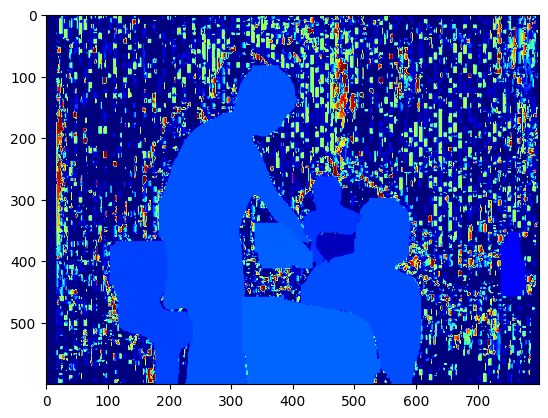

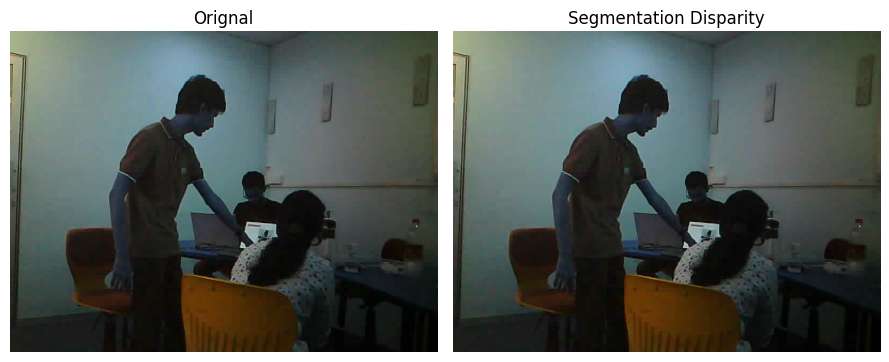

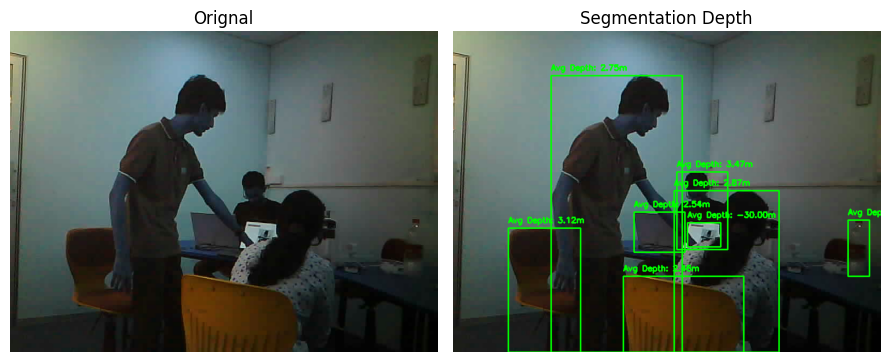

In [32]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=5)
disparity = stereo.compute(left_img, right_img)

img_temp = segmentation_disparity(left_color_img, disparity)

viewImages(left_color_img, img_temp, "Segmentation Disparity")
img_temp = segmentation_depth(left_color_img, disparity)
viewImages(left_color_img, img_temp, "Segmentation Depth")